# Improve Recommendation System

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import cross_val_score

## Import Dataset

###Movielenz Dataset

In [4]:
moviesDataset = pd.read_csv('/content/drive/MyDrive/Dataset/Movielenz/movies.dat',encoding='latin-1',delimiter='::',engine='python')
usersDataset = pd.read_csv('/content/drive/MyDrive/Dataset/Movielenz/users.dat',encoding='latin-1',delimiter='::',engine='python')
ratingsDataset = pd.read_csv('/content/drive/MyDrive/Dataset/Movielenz/ratings.dat',encoding='latin-1',delimiter='::',engine='python')
pd.set_option('display.max_columns', None)

## Data Cleaning

### Set Column Names

In [5]:
moviesDataset.columns = ['MovieId','MovieTitle','Genres']

In [6]:
usersDataset.columns = ['UserID','Gender','Age','Occupation','Zip-code']

In [7]:
ratingsDataset.columns = ['UserID','MovieID','Rating','Timestamp']

### Check Null values

In [8]:
row_nulls_movies = moviesDataset.isnull().any(axis=1)
rows_with_nulls = moviesDataset[row_nulls_movies]
print(rows_with_nulls)

Empty DataFrame
Columns: [MovieId, MovieTitle, Genres]
Index: []


In [9]:
row_nulls_users = usersDataset.isnull().any(axis=1)
rows_with_nulls = usersDataset[row_nulls_users]
print(rows_with_nulls)

Empty DataFrame
Columns: [UserID, Gender, Age, Occupation, Zip-code]
Index: []


In [10]:
row_nulls_ratings = ratingsDataset.isnull().any(axis=1)
rows_with_nulls = ratingsDataset[row_nulls_ratings]
print(rows_with_nulls)

Empty DataFrame
Columns: [UserID, MovieID, Rating, Timestamp]
Index: []


### Check Duplicate Rows

In [11]:
duplicated_rows_in_movies = moviesDataset[moviesDataset.duplicated()]
if duplicated_rows_in_movies.empty :
    print("No duplicate rows found .")
else:
    print("Duplicate rows found .")

No duplicate rows found .


In [12]:
duplicated_rows_in_users = usersDataset[usersDataset.duplicated()]
if duplicated_rows_in_users.empty :
    print("No duplicate rows found .")
else:
    print("Duplicate rows found .")

No duplicate rows found .


In [13]:
duplicated_rows_in_Ratings = ratingsDataset[ratingsDataset.duplicated()]
if duplicated_rows_in_Ratings.empty :
    print("No duplicate rows found .")
else:
    print("Duplicate rows found .")

No duplicate rows found .


### One Hot Encoding Gender column

In [14]:
from sklearn.preprocessing import LabelBinarizer
gender_column = usersDataset['Gender']
obj = LabelBinarizer()
result_column = obj.fit_transform(gender_column)
usersDataset['Male'] = result_column
usersDataset['Female'] = 1-usersDataset['Male']
columns_to_drop = ['Gender']
usersDataset.drop(columns=columns_to_drop, inplace=True)

### One Hot Encoding for Occupation Column

In [15]:
from sklearn.preprocessing import LabelBinarizer
occupation_column = usersDataset['Occupation']
obj = LabelBinarizer()
result_column = obj.fit_transform(occupation_column)
result_df = pd.DataFrame(result_column)
usersDataset = pd.concat([usersDataset, result_df], axis=1)

new_column_names = {
    0: 'Other',
    1: 'Academic/Educator',
    2: 'Artist',
    3: 'Clerical/Admin',
    4: 'College/Grad Student',
    5: 'Customer Service',
    6: 'Doctor/Health Care',
    7: 'Executive/Managerial',
    8: 'Farmer',
    9: 'HomeMaker',
    10: 'K-12 Student',
    11: 'Lawyer',
    12: 'Programmer',
    13: 'Retired',
    14: 'Sales/Marketing',
    15: 'Scientist',
    16: 'Self-Employed',
    17: 'Technician/Engineer',
    18: 'Tradesman/Craftsman',
    19: 'Unemployed',
    20: 'Writer'
}

usersDataset = usersDataset.rename(columns=new_column_names)


In [16]:
columns_to_drop = ['Occupation','Zip-code']
usersDataset.drop(columns=columns_to_drop, inplace=True)

### One Hot Encoding for Age Column

In [17]:
from sklearn.preprocessing import LabelBinarizer
age_column = usersDataset['Age']
obj = LabelBinarizer()
result_column = obj.fit_transform(age_column)
result_df = pd.DataFrame(result_column)
usersDataset = pd.concat([usersDataset, result_df], axis=1)

new_column_names = {
    0: 'Under 18',
    1: '18-24',
    2: '25-34',
    3: '35-44',
    4: '45-49',
    5: '50-55',
    6: '56+'
}

usersDataset = usersDataset.rename(columns=new_column_names)


In [18]:
columns_to_drop = ['Age']
usersDataset.drop(columns=columns_to_drop, inplace=True)

### Split Film Title and Year

In [19]:
moviesDataset[['Title', 'Year']] = moviesDataset['MovieTitle'].str.extract(r'(.+)\s\((\d{4})\)')

In [20]:
columns_to_drop = ['MovieTitle']
moviesDataset.drop(columns=columns_to_drop, inplace=True)

### Genres Splits to Movie Type

In [21]:
moviesDataset['Genres'].head()

,Genres
0,Adventure|Children's|Fantasy
1,Comedy|Romance
2,Comedy|Drama
3,Comedy
4,Action|Crime|Thriller


In [22]:
split_data = moviesDataset['Genres'].str.get_dummies("|")

In [23]:
moviesDataset = pd.concat([moviesDataset, split_data], axis=1)

In [24]:
columns_to_drop = ['Genres']
moviesDataset.drop(columns=columns_to_drop, inplace=True)

### Scale Timestamp based on old and newest

In [25]:
dateTime = pd.to_datetime(ratingsDataset['Timestamp'], unit='s')

In [26]:
ratingsDataset['ratedDate'] = dateTime.dt.date
#ratingsDataset['Time'] = dateTime.dt.time
ratingsDataset['ratedTime'] = dateTime.dt.round('H').dt.time
#ratingsDataset['ratedTime'] = ratingsDataset['ratedTime'].dt.round('H')

<ipython-input-26-6a5a7078dd30>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ratingsDataset['ratedTime'] = dateTime.dt.round('H').dt.time


In [27]:
columns_to_drop = ['Timestamp']
ratingsDataset.drop(columns=columns_to_drop, inplace=True)

### Join Datasets

In [28]:
merged_df = pd.merge(ratingsDataset, usersDataset, on='UserID')

### Show Joins

In [29]:
merged_df.head(20)

,UserID,MovieID,Rating,ratedDate,ratedTime,Male,Female,Other,Academic/Educator,Artist,Clerical/Admin,College/Grad Student,Customer Service,Doctor/Health Care,Executive/Managerial,Farmer,HomeMaker,K-12 Student,Lawyer,Programmer,Retired,Sales/Marketing,Scientist,Self-Employed,Technician/Engineer,Tradesman/Craftsman,Unemployed,Writer,Under 18,18-24,25-34,35-44,45-49,50-55,56+
0,2,1357,5,2000-12-31,22:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,2,3068,4,2000-12-31,22:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,2,1537,4,2000-12-31,22:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,2,647,3,2000-12-31,22:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,2,2194,4,2000-12-31,22:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
5,2,648,4,2000-12-31,22:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
6,2,2268,5,2000-12-31,22:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
7,2,2628,3,2000-12-31,22:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
8,2,1103,3,2000-12-31,22:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
9,2,2916,3,2000-12-31,22:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


### Rename MovieID Column

In [30]:
merged_df.rename(columns={'MovieID': 'MovieId'}, inplace=True)
merged_df.head()

,UserID,MovieId,Rating,ratedDate,ratedTime,Male,Female,Other,Academic/Educator,Artist,Clerical/Admin,College/Grad Student,Customer Service,Doctor/Health Care,Executive/Managerial,Farmer,HomeMaker,K-12 Student,Lawyer,Programmer,Retired,Sales/Marketing,Scientist,Self-Employed,Technician/Engineer,Tradesman/Craftsman,Unemployed,Writer,Under 18,18-24,25-34,35-44,45-49,50-55,56+
0,2,1357,5,2000-12-31,22:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,2,3068,4,2000-12-31,22:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,2,1537,4,2000-12-31,22:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,2,647,3,2000-12-31,22:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,2,2194,4,2000-12-31,22:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [31]:
merged_full = pd.merge(merged_df,moviesDataset,on='MovieId')

In [32]:
# Assuming 'merged_full' is your DataFrame and 'Year' and 'Date' are its columns.

# Convert 'Year' to datetime and set all to January 1st of that year
movieReleaseDate = pd.to_datetime(merged_full['Year'], format='%Y')
#movieReleaseDate = merged_full['Year'] + pd.offsets.DateOffset(months=0, days=0)

# Ensure 'Date' is in datetime format
merged_full['ratedDate'] = pd.to_datetime(merged_full['ratedDate'])

# Calculate the difference in days
merged_full['rateDaysSinceRelease'] = (merged_full['ratedDate'] - movieReleaseDate).dt.days

## Check Joins  

In [33]:
userId1 = usersDataset[usersDataset['UserID'] == 2]

In [34]:
moviesId1 = moviesDataset[moviesDataset['MovieId'] == 1357]

In [35]:
ratingId1 = ratingsDataset[(ratingsDataset['MovieID'] == 1357) & (ratingsDataset['UserID'] == 2)]

In [36]:
userId2 = usersDataset[usersDataset['UserID'] == 1500]

In [37]:
ratingId2 = ratingsDataset[ratingsDataset['UserID'] == 1500]

In [38]:
row = merged_full[(merged_full['UserID']==1500) & (merged_full['MovieId'] == 3791)]

### Join Dataframe Size

In [39]:
merged_full.shape[0]

998080

## Descriptive Analysis

###  Describe function

In [40]:
selected_columns = ['Rating','ratedDate','ratedTime','Year','rateDaysSinceRelease']

# Get summary statistics for the selected columns
merged_full[selected_columns].describe()


,Rating,ratedDate,rateDaysSinceRelease
count,998080.000000,998080,998080.000000
mean,3.580357,2000-10-22 08:09:46.630329984,5159.628878
min,1.000000,2000-04-25 00:00:00,116.000000
25%,3.000000,2000-08-03 00:00:00,1440.000000
50%,4.000000,2000-10-31 00:00:00,3245.000000
75%,4.000000,2000-11-26 00:00:00,6766.000000
max,5.000000,2003-02-28 00:00:00,30256.000000
std,1.117300,NaN,5242.641570


In [41]:
#Gender
merged_full[selected_columns].describe(include=['object'])

,ratedTime,Year
count,998080,998080
unique,24,81
top,22:00:00,1999
freq,63951,86829


### Univariate Analysis

#### Histogram

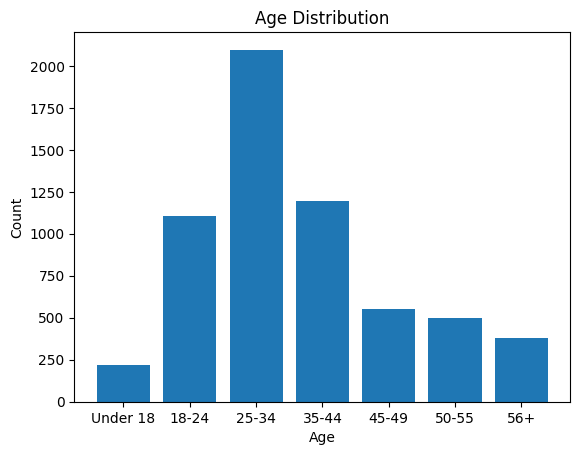

In [42]:
# Names and values for the bar chart
group1 = (usersDataset['Under 18'] == 1).sum()
group2 = (usersDataset['18-24'] == 1).sum()
group3 = (usersDataset['25-34'] == 1).sum()
group4 = (usersDataset['35-44'] == 1).sum()
group5 = (usersDataset['45-49'] == 1).sum()
group6 = (usersDataset['50-55'] == 1).sum()
group7 = (usersDataset['56+'] == 1).sum()


AgeGroup = ['Under 18', '18-24','25-34','35-44','45-49','50-55','56+']
values = [group1, group2,group3,group4,group5,group6,group7]

plt.bar(AgeGroup, values)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()


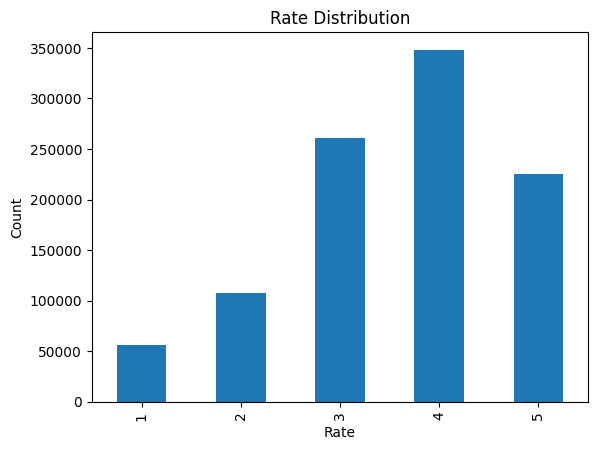

In [43]:
# Bin the 'Age' column into intervals
bins = [0,1, 2, 3, 4, 5]  # Define the bin edges
labels = ['1', '2', '3', '4','5']  # Define the bin labels
rate_group = pd.cut(merged_full['Rating'], bins=bins, labels=labels)

# Count the occurrences in each bin
age_group_counts = rate_group.value_counts().sort_index()

# Plot the bar chart
age_group_counts.plot(kind='bar')
plt.xlabel('Rate')
plt.ylabel('Count')
plt.title('Rate Distribution')
plt.show()

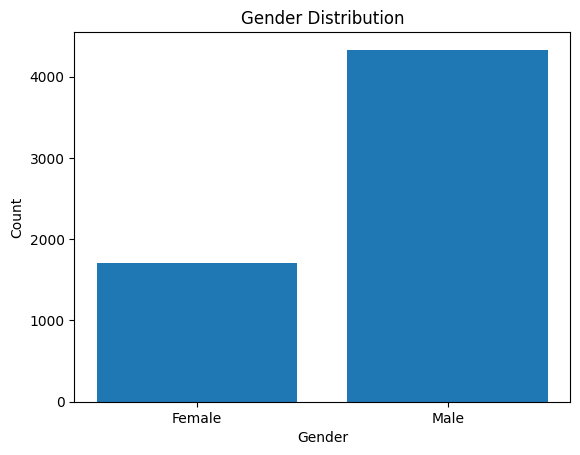

In [44]:
male = usersDataset['Male'] == 1
female = usersDataset['Female'] == 1

# Count the number of True values in each Series
male_count = male.sum()
female_count = female.sum()

# Names and values for the bar chart
names = ['Female', 'Male']
values = [female_count, male_count]

plt.bar(names, values)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.show()


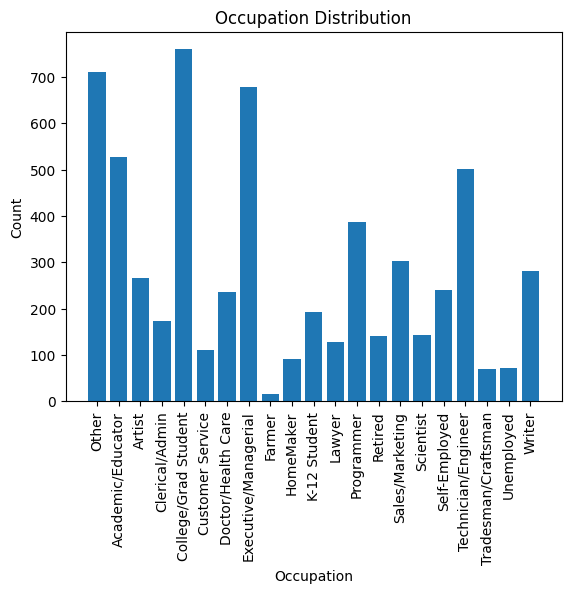

In [45]:
# Names and values for the bar chart
other = (usersDataset['Other'] == 1).sum()
academic = (usersDataset['Academic/Educator'] == 1).sum()
artist = (usersDataset['Artist'] == 1).sum()
clerical = (usersDataset['Clerical/Admin'] == 1).sum()
college = (usersDataset['College/Grad Student'] == 1).sum()
customer_service = (usersDataset['Customer Service'] == 1).sum()
doctor = (usersDataset['Doctor/Health Care'] == 1).sum()
executive = (usersDataset['Executive/Managerial'] == 1).sum()
farmer = (usersDataset['Farmer'] == 1).sum()
homemaker = (usersDataset['HomeMaker'] == 1).sum()
k12_student = (usersDataset['K-12 Student'] == 1).sum()
lawyer = (usersDataset['Lawyer'] == 1).sum()
programmer = (usersDataset['Programmer'] == 1).sum()
retired = (usersDataset['Retired'] == 1).sum()
sales = (usersDataset['Sales/Marketing'] == 1).sum()
scientist = (usersDataset['Scientist'] == 1).sum()
self_employed = (usersDataset['Self-Employed'] == 1).sum()
technician = (usersDataset['Technician/Engineer'] == 1).sum()
tradesman = (usersDataset['Tradesman/Craftsman'] == 1).sum()
unemployed = (usersDataset['Unemployed'] == 1).sum()
writer = (usersDataset['Writer'] == 1).sum()

occupation = [
    'Other',
    'Academic/Educator',
    'Artist',
    'Clerical/Admin',
    'College/Grad Student',
    'Customer Service',
    'Doctor/Health Care',
    'Executive/Managerial',
    'Farmer',
    'HomeMaker',
    'K-12 Student',
    'Lawyer',
    'Programmer',
    'Retired',
    'Sales/Marketing',
    'Scientist',
    'Self-Employed',
    'Technician/Engineer',
    'Tradesman/Craftsman',
    'Unemployed',
    'Writer'
    ]
values = [other, academic,artist,clerical,college,customer_service,doctor,executive,farmer,homemaker,k12_student,lawyer,programmer,retired,sales,scientist,self_employed,technician,tradesman,unemployed,writer]

plt.bar(occupation, values)
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Occupation Distribution')
plt.show()

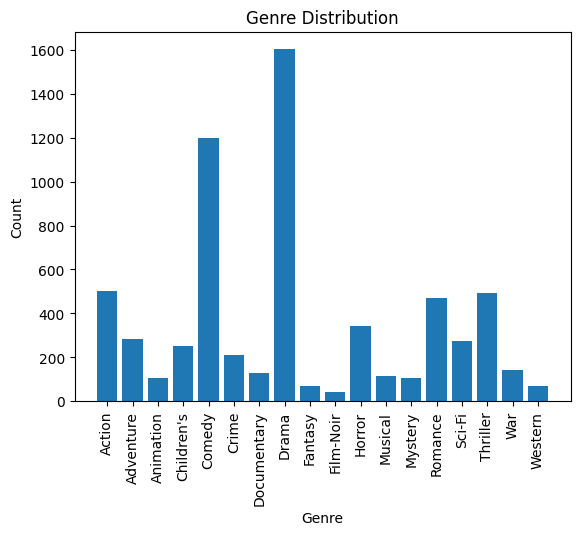

In [46]:
action = (moviesDataset['Action'] == 1).sum()
adventure = (moviesDataset['Adventure'] == 1).sum()
animation = (moviesDataset['Animation'] == 1).sum()
childrens = (moviesDataset['Children\'s'] == 1).sum()
comedy = (moviesDataset['Comedy'] == 1).sum()
crime = (moviesDataset['Crime'] == 1).sum()
documentary = (moviesDataset['Documentary'] == 1).sum()
drama = (moviesDataset['Drama'] == 1).sum()
fantasy = (moviesDataset['Fantasy'] == 1).sum()
film_noir = (moviesDataset['Film-Noir'] == 1).sum()
horror = (moviesDataset['Horror'] == 1).sum()
musical = (moviesDataset['Musical'] == 1).sum()
mystery = (moviesDataset['Mystery'] == 1).sum()
romance = (moviesDataset['Romance'] == 1).sum()
sci_fi = (moviesDataset['Sci-Fi'] == 1).sum()
thriller = (moviesDataset['Thriller'] == 1).sum()
war = (moviesDataset['War'] == 1).sum()
western = (moviesDataset['Western'] == 1).sum()


names = [
    'Action',
    'Adventure',
    'Animation',
    'Children\'s',
    'Comedy',
    'Crime',
    'Documentary',
    'Drama',
    'Fantasy',
    'Film-Noir',
    'Horror',
    'Musical',
    'Mystery',
    'Romance',
    'Sci-Fi',
    'Thriller',
    'War',
    'Western'
    ]
values = [action, adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western]

plt.bar(names, values)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Genre Distribution')
plt.show()

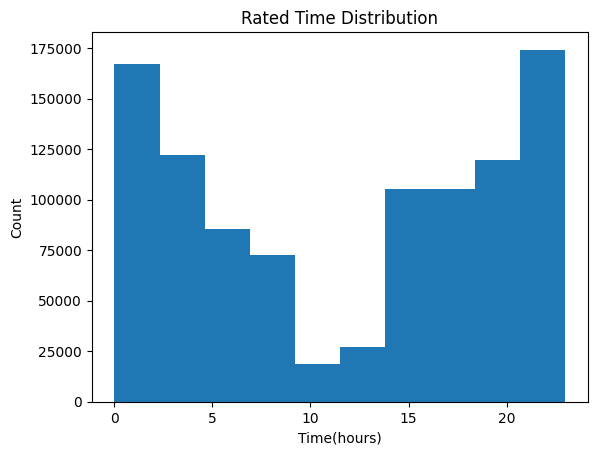

In [47]:
def time_to_float(t):
    return t.hour + t.minute / 60 + t.second / 3600

# Apply the conversion function to the 'ratedTime' column
ratedTimeFloat = merged_full['ratedTime'].apply(time_to_float)
plt.hist(ratedTimeFloat)
plt.xlabel('Time(hours)')
plt.ylabel('Count')
plt.title('Rated Time Distribution')
plt.show()

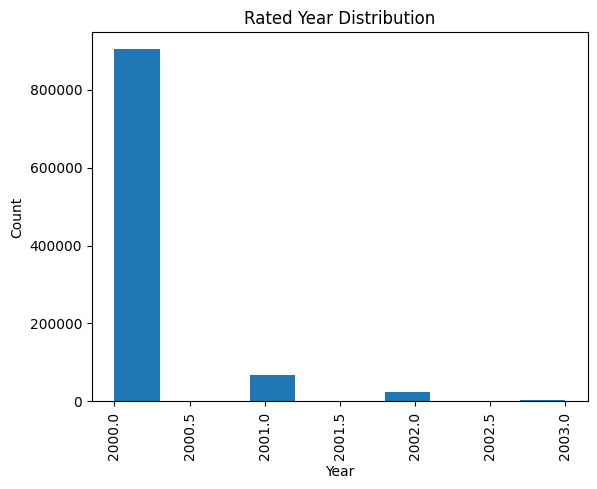

In [48]:
ratedYear = merged_full['ratedDate'].dt.year
plt.hist(ratedYear)
plt.xlabel('Year')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Rated Year Distribution')
plt.show()

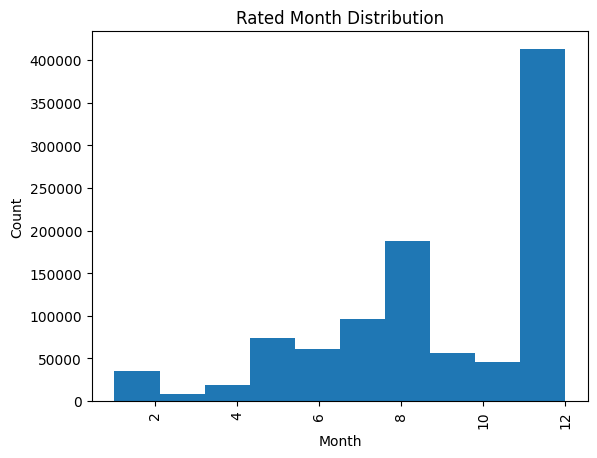

In [49]:
ratedMonth = merged_full['ratedDate'].dt.month
plt.hist(ratedMonth)
plt.xlabel('Month')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Rated Month Distribution')
plt.show()

#### Box Plot

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


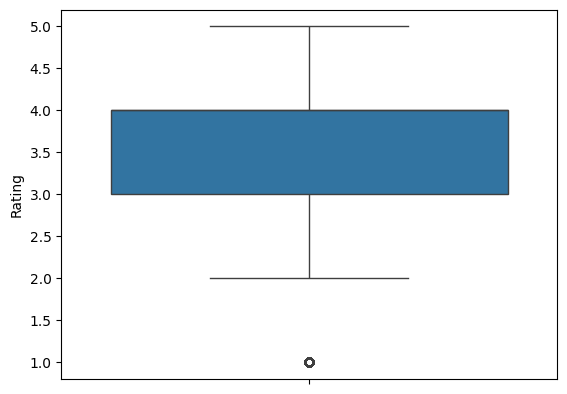

In [50]:
# for rating
sns.boxplot(merged_full['Rating'])
plt.show()

### Bivariate Analysis

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


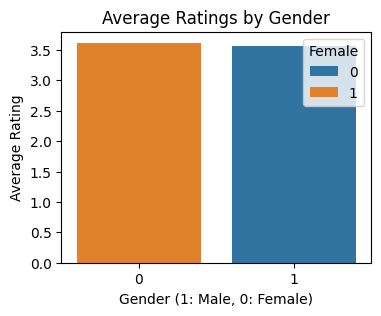

In [51]:
gender_avg_rating = merged_full.groupby(['Male', 'Female'])['Rating'].mean().reset_index()
gender_avg_rating.columns = ['Male', 'Female', 'Average Rating']

# Plot
plt.figure(figsize=(4, 3))
sns.barplot(data=gender_avg_rating, x='Male', y='Average Rating', hue='Female')
plt.title('Average Ratings by Gender')
plt.xlabel('Gender (1: Male, 0: Female)')
plt.ylabel('Average Rating')
plt.legend(title='Female')
plt.show()

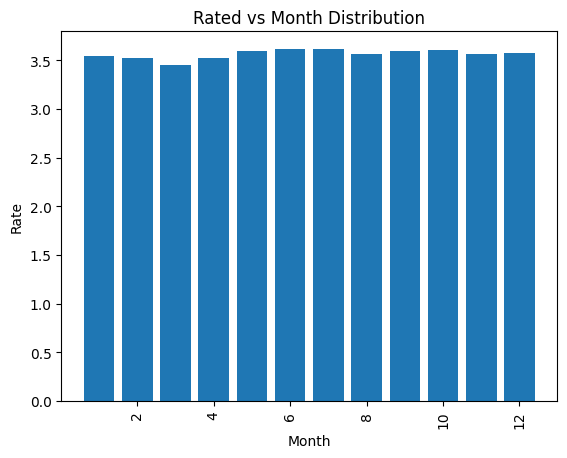

In [52]:
merged_full['Month'] = merged_full['ratedDate'].dt.month
rate = merged_full.groupby('Month')['Rating'].mean().reset_index()

# Plot the results

plt.bar(rate['Month'], rate['Rating'])
plt.xlabel('Month')
plt.xticks(rotation=90)
plt.ylabel('Rate')
plt.title('Rated vs Month Distribution')
plt.show()

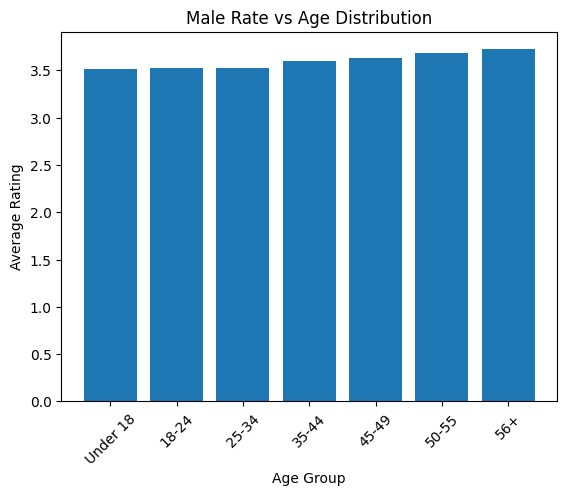

In [53]:
age_groups = ['Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']

# List to store mean ratings for each age group
mean_ratings = []

# Loop through each age group, filter, group, and compute mean rating
for age_group in age_groups:
    group = merged_full[(merged_full['Male'] == 1) & (merged_full[age_group] == 1)]
    mean_rating = group['Rating'].mean()
    mean_ratings.append(mean_rating)

# Plot the results
plt.bar(age_groups, mean_ratings)
plt.xlabel('Age Group')
plt.ylabel('Average Rating')
plt.title('Male Rate vs Age Distribution')
plt.xticks(rotation=45)
plt.show()

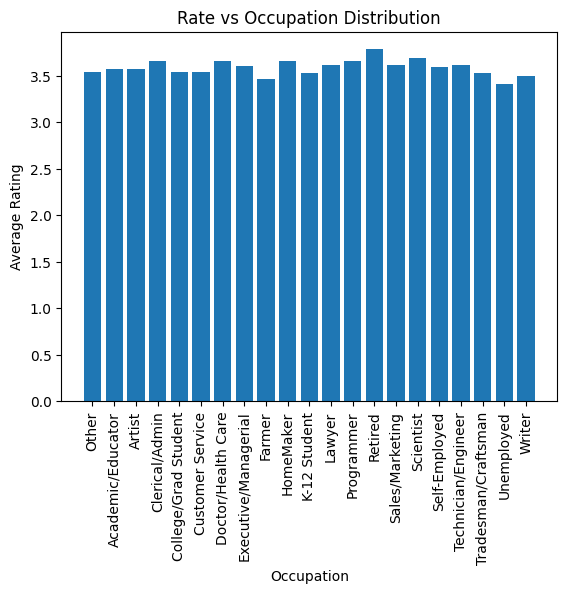

In [54]:
occupations = [
    'Other',
    'Academic/Educator',
    'Artist',
    'Clerical/Admin',
    'College/Grad Student',
    'Customer Service',
    'Doctor/Health Care',
    'Executive/Managerial',
    'Farmer',
    'HomeMaker',
    'K-12 Student',
    'Lawyer',
    'Programmer',
    'Retired',
    'Sales/Marketing',
    'Scientist',
    'Self-Employed',
    'Technician/Engineer',
    'Tradesman/Craftsman',
    'Unemployed',
    'Writer'
    ]

mean_ratings = []

# Loop through each age group, filter, group, and compute mean rating
for occupation in occupations:
    group = merged_full[(merged_full[occupation] == 1)]
    mean_rating = group['Rating'].mean()
    mean_ratings.append(mean_rating)

# Plot the results
plt.bar(occupations, mean_ratings)
plt.xlabel('Occupation')
plt.ylabel('Average Rating')
plt.title('Rate vs Occupation Distribution')
plt.xticks(rotation=90)
plt.show()

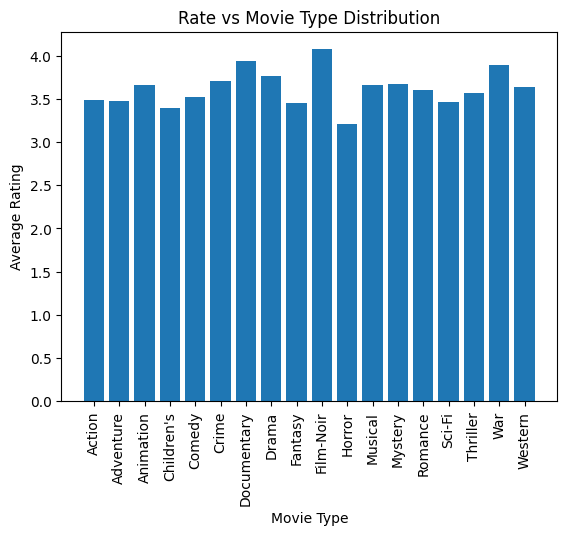

In [55]:
movieTypes = [
    'Action',
    'Adventure',
    'Animation',
    'Children\'s',
    'Comedy',
    'Crime',
    'Documentary',
    'Drama',
    'Fantasy',
    'Film-Noir',
    'Horror',
    'Musical',
    'Mystery',
    'Romance',
    'Sci-Fi',
    'Thriller',
    'War',
    'Western'
    ]

mean_ratings = []

# Loop through each age group, filter, group, and compute mean rating
for movieType in movieTypes:
    group = merged_full[(merged_full[movieType] == 1)]
    mean_rating = group['Rating'].mean()
    mean_ratings.append(mean_rating)

# Plot the results
plt.bar(movieTypes, mean_ratings)
plt.xlabel('Movie Type')
plt.ylabel('Average Rating')
plt.title('Rate vs Movie Type Distribution')
plt.xticks(rotation=90)
plt.show()

## Split train and test data

### Whole Dataset

In [56]:
columns_to_drop = ['ratedDate','ratedTime','Title','Year']
merged_full.drop(columns=columns_to_drop, inplace=True)

In [57]:
merged_full.head()
sampled_df = merged_full.sample(n=200000, random_state=42)

In [58]:
x = sampled_df.drop('Rating',axis=1)

In [59]:
# Apply the lambda function to the 'Rating' column
y = sampled_df['Rating']

In [60]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2)

### Main 3 Occupation

In [61]:
subDataset = merged_full[(merged_full['Other'] == 1) | (merged_full['College/Grad Student'] == 1) | (merged_full['Executive/Managerial'] == 1)]
#subDataset = merged_full[(merged_full['Other'] == 1)]

In [62]:
x_sub = subDataset.drop('Rating',axis=1)
y_sub = subDataset['Rating']

from sklearn.model_selection import train_test_split
x_train_sub,x_test_sub,y_train_sub,y_test_sub = train_test_split(x_sub,y_sub,test_size = 0.2)

### Unemployed Dataset

In [63]:
unemployedDataset = merged_full[(merged_full['Unemployed'] == 1)]
#subDataset = merged_full[(merged_full['Other'] == 1)]

In [64]:
x_sub_1 = subDataset.drop('Rating',axis=1)
y_sub_1 = subDataset['Rating']

from sklearn.model_selection import train_test_split
x_train_sub_1,x_test_sub_1,y_train_sub_1,y_test_sub_1 = train_test_split(x_sub_1,y_sub_1,test_size = 0.2)

## Model Implemetation

### KNN Model Implement

In [65]:
from sklearn.neighbors import KNeighborsClassifier

def findBestK(x_train,y_train,x_test,y_test,start,end,step):
    for k in range (start,end,step):
        from sklearn.neighbors import KNeighborsClassifier
        #model = KNeighborsClassifier(metric='manhattan', n_neighbors=160, weights='distance')
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(x_train,y_train)
        pred = model.predict(np.array(x_test))
        from sklearn.metrics import accuracy_score
        accuracy = accuracy_score(y_test,pred)
        bestAccuracy =0
        bestKValue =1

        if bestAccuracy<accuracy:
            bestAccuracy = accuracy
            bestKValue = k
        print(k)
        print(accuracy)
    return bestKValue,bestAccuracy

def findBestKCrossValidation(x,y):
  model = KNeighborsClassifier(metric='manhattan', n_neighbors=160, weights='distance')
  #model = KNeighborsClassifier(n_neighbors=160)
  cv_scores = cross_val_score(model, x, y, cv=10)
  mean_cv_score = np.mean(cv_scores)
  print(mean_cv_score)
  return mean_cv_score

def KNNModelImplement(x_train,y_train):
  model = KNeighborsClassifier(metric='manhattan', n_neighbors=160, weights='distance')
  model.fit(x_train,y_train)
  pred = model.predict(np.array(x_test))
  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score(y_test,pred)
  return accuracy

### KNN Model Optimize

In [66]:
def OptimizeKNN(x_train, y_train):
    #Optimize Hyper Parameters
    from sklearn.model_selection import GridSearchCV
    from sklearn.neighbors import KNeighborsClassifier

    # Define the parameter distribution
    param_dist = {
        'n_neighbors': [40],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }

    # Initialize the KNN classifier
    knn = KNeighborsClassifier()

    # Set up the random search with cross-validation
    random_search = GridSearchCV(knn, param_dist, cv=5, scoring='accuracy')

    # Fit the random search to the data
    random_search.fit(x_train, y_train)

    # Best parameters and score
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best score: {random_search.best_score_}")


### K Means Model Implement

In [67]:
def BestKForKMeanModel(dataset):

    from sklearn.preprocessing import StandardScaler
    user_item_matrix = dataset.pivot(index='UserID', columns='MovieId', values='Rating').fillna(0)

    # Normalize the data
    scaler = StandardScaler()
    user_item_matrix_normalized = scaler.fit_transform(user_item_matrix)

    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans

    sse = []
    for k in range(1, 100,20):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(user_item_matrix_normalized)
        sse.append(kmeans.inertia_)

    plt.plot(range(1, 100,20), sse, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()


def AccuracyForKMeanModel(dataset):

    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans

    # Determine the number of clusters (k)
    k = 20  # You can choose an appropriate value or use the elbow method to find the optimal k

    # Initialize and fit K-means
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dataset)

    # Get cluster labels
    labels = kmeans.labels_

    # Add cluster labels to the original dataframe
    dataset['Cluster'] = labels

    df_clusters = dataset.reset_index()[['UserID', 'Cluster']]

    # Display users in each cluster
    clusters = df_clusters.groupby('Cluster')

    from sklearn.metrics import silhouette_score
    score = silhouette_score(dataset, labels)
    print(f'Silhouette Score: {score}')

### Hybrid Model

In [68]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def HybridModelImplement(dataset, n_clusters=3):
    # Initialize KMeans with the desired number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    # Fit the KMeans model and get the cluster labels
    cluster_labels = kmeans.fit_predict(dataset)

    # Add the cluster labels as a new feature to the original dataset
    X_clustered = dataset.copy()
    X_clustered['cluster_labels'] = cluster_labels

    accuracies = []

    # Iterate through each cluster
    for cluster_number in range(n_clusters):
        # Filter the dataset to include only the specified cluster
        X_cluster = X_clustered[X_clustered['cluster_labels'] == cluster_number]

        # Define the feature matrix (X) and the target variable (y)
        X = X_cluster.drop(['Rating', 'cluster_labels'], axis=1)
        y = X_cluster['Rating']

        # If there's not enough data to split, skip this cluster
        if len(X) < 2:
            continue

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Initialize the KNN classifier with desired parameters
        knn_classifier = KNeighborsClassifier(metric='manhattan', n_neighbors=1, weights='distance')

        # Fit the KNN model to the training data
        knn_classifier.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = knn_classifier.predict(X_test)

        # Evaluate the accuracy of the KNN model
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        print(f'Accuracy for cluster {cluster_number}: {accuracy:.2f}')

    # Compute the mean accuracy across all clusters
    if accuracies:
        mean_accuracy = np.mean(accuracies)
        print(f'Mean accuracy across all clusters: {mean_accuracy:.2f}')
    else:
        print('No clusters with sufficient data to evaluate accuracy.')




### MLP Implementation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

class NeuMFModel:
    def __init__(self, latent_dim=8, hidden_units=[64, 32], dropout_rate=0.2, l2_reg=0.01, batch_size=256, epochs=5):
        self.latent_dim = latent_dim
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate
        self.l2_reg = l2_reg
        self.batch_size = batch_size
        self.epochs = epochs
        self.encoder = None
        self.user_mapping = None
        self.movie_mapping = None
        self.rating_mapping = None
        self.feature_columns = None
        self.model = None

    def preprocess_data(self, data, feature_columns):
      self.feature_columns = feature_columns

      # Map users, movies, and ratings to indices
      user_ids = data['UserID'].unique()
      movie_ids = data['MovieId'].unique()
      ratings_values = data['Rating'].unique()

      self.user_mapping = {user: i for i, user in enumerate(user_ids)}
      self.movie_mapping = {movie: i for i, movie in enumerate(movie_ids)}
      self.rating_mapping = {rating: i for i, rating in enumerate(ratings_values)}

      data['user'] = data['UserID'].map(self.user_mapping)
      data['movie'] = data['MovieId'].map(self.movie_mapping)
      data['rating_encoded'] = data['Rating'].map(self.rating_mapping)

      # Encode ratings as one-hot vectors
      self.encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Ensure sparse_output=False
      y_encoded = self.encoder.fit_transform(data[['rating_encoded']])

      # Prepare demographic and genre data
      X_features = data[feature_columns].values

      # Split data into train and test
      train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

      # Prepare inputs for TensorFlow
      X_train = [train_data['user'].values, train_data['movie'].values, X_features[train_data.index]]
      y_train = self.encoder.transform(train_data[['rating_encoded']])  # Already non-sparse due to sparse_output=False
      X_test = [test_data['user'].values, test_data['movie'].values, X_features[test_data.index]]
      y_test = self.encoder.transform(test_data[['rating_encoded']])

      return (X_train, y_train), (X_test, y_test)


    def create_dataset(self, user_data, movie_data, features_data, labels, shuffle=True):
        dataset = tf.data.Dataset.from_tensor_slices(((user_data, movie_data, features_data), labels))
        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(user_data))
        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset

    def build_model(self, num_users, num_movies, num_ratings, num_features):
        # GMF model
        user_input = Input(shape=[1], name='user')
        movie_input = Input(shape=[1], name='movie')
        features_input = Input(shape=[num_features], name='features')

        user_embedding_gmf = Embedding(num_users, self.latent_dim, embeddings_regularizer=l2(self.l2_reg))(user_input)
        movie_embedding_gmf = Embedding(num_movies, self.latent_dim, embeddings_regularizer=l2(self.l2_reg))(movie_input)
        user_embedding_gmf = Flatten()(user_embedding_gmf)
        movie_embedding_gmf = Flatten()(movie_embedding_gmf)

        gmf_vector = tf.keras.layers.Multiply()([user_embedding_gmf, movie_embedding_gmf])

        # MLP model with Dropout and L2 Regularization
        user_embedding_mlp = Embedding(num_users, self.latent_dim, embeddings_regularizer=l2(self.l2_reg))(user_input)
        movie_embedding_mlp = Embedding(num_movies, self.latent_dim, embeddings_regularizer=l2(self.l2_reg))(movie_input)
        user_embedding_mlp = Flatten()(user_embedding_mlp)
        movie_embedding_mlp = Flatten()(movie_embedding_mlp)

        mlp_vector = Concatenate()([user_embedding_mlp, movie_embedding_mlp, features_input])
        for units in self.hidden_units:
            mlp_vector = Dense(units, activation='relu', kernel_regularizer=l2(self.l2_reg))(mlp_vector)
            mlp_vector = Dropout(self.dropout_rate)(mlp_vector)

        # NeuMF model
        merged_vector = Concatenate()([gmf_vector, mlp_vector])
        output = Dense(num_ratings, activation='softmax')(merged_vector)

        self.model = Model(inputs=[user_input, movie_input, features_input], outputs=output)
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    def train(self, train_data, test_data):
        X_train, y_train = train_data  # Unpack train data
        X_test, y_test = test_data    # Unpack test data
        train_dataset = self.create_dataset(*X_train, y_train, shuffle=True)  # Pass labels to create_dataset
        test_dataset = self.create_dataset(*X_test, y_test, shuffle=False)   # Pass labels to create_dataset

        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        self.model.fit(
            train_dataset,
            epochs=self.epochs,
            validation_data=test_dataset,
            callbacks=[early_stopping]
        )



    def evaluate(self, X_test, y_test):
      # Extract user_data, movie_data, features_data from X_test
      user_data, movie_data, features_data = X_test

      # Convert y_test from one-hot encoded format to labels
      y_true = np.argmax(y_test, axis=1)

      # Create dataset using the provided method
      test_dataset = self.create_dataset(user_data, movie_data, features_data, y_test, shuffle=False)

      # Predict probabilities for the test dataset
      y_pred_proba = self.model.predict(test_dataset)

      # Convert probabilities to predicted class labels
      y_pred = np.argmax(y_pred_proba, axis=1)

      # Calculate various evaluation metrics
      precision = precision_score(y_true, y_pred, average='weighted')
      recall = recall_score(y_true, y_pred, average='weighted')
      f1 = f1_score(y_true, y_pred, average='weighted')
      accuracy = accuracy_score(y_true, y_pred)

      # Print the calculated metrics
      print(f"Precision: {precision:.4f}")
      print(f"Recall: {recall:.4f}")
      print(f"F1 Score: {f1:.4f}")
      print(f"Accuracy: {accuracy:.4f}")

      # Print the classification report
      print("Classification Report:")
      print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(len(np.unique(y_true)))]))

      def hit_ratio(y_true, y_pred, top_k=10):
        hr_list = []
        for true_label, pred_probs in zip(y_true, y_pred):
            top_k_preds = np.argsort(pred_probs)[::-1][:top_k]
            hr_list.append(1 if true_label in top_k_preds else 0)
        return np.mean(hr_list)


      def ndcg(y_true, y_pred, top_k=10):
        def dcg_at_k(r, k):
            return np.sum((2 ** np.array(r) - 1) / np.log2(np.arange(2, len(r) + 2)))

        def ndcg_at_k(r, k):
            ideal_dcg = dcg_at_k(sorted(r, reverse=True), k)
            actual_dcg = dcg_at_k(r[:k], k)
            return actual_dcg / ideal_dcg if ideal_dcg > 0 else 0

        ndcg_list = []
        for true_label, pred_probs in zip(y_true, y_pred):
            top_k_preds = np.argsort(pred_probs)[::-1][:top_k]
            relevance_scores = [1 if i == true_label else 0 for i in top_k_preds]
            ndcg_list.append(ndcg_at_k(relevance_scores, top_k))
        return np.mean(ndcg_list)

      # Calculate Hit Ratio (HR) and NDCG
      hr = hit_ratio(y_true, y_pred_proba)
      ndcg_score = ndcg(y_true, y_pred_proba)

      # Print the HR and NDCG metrics
      print(f"Hit Ratio (HR) at 10: {hr:.4f}")
      print(f"NDCG at 10: {ndcg_score:.4f}")

      # Return all the calculated metrics
      return precision, recall, f1, accuracy, hr, ndcg_score


    from sklearn.metrics.pairwise import cosine_similarity


    def find_similar_users(self,user_id, user_demographics, demographics_df, top_n=10):

        # Convert user demographics to DataFrame
        user_df = pd.DataFrame([user_demographics], index=[user_id])

        # Combine with existing demographics
        combined_df = pd.concat([demographics_df, user_df], axis=0)

        # Compute similarity matrix
        similarities = cosine_similarity(combined_df, combined_df)

        # Get similarity scores for the given user
        user_similarities = similarities[-1][:-1]  # Exclude the similarity with itself

        # Get top_n most similar users
        similar_user_indices = np.argsort(user_similarities)[::-1][:top_n]
        similar_users = demographics_df.index[similar_user_indices].tolist()

        return similar_users

    def get_popular_movies(similar_users, merged_full, moviesDataset, top_n=10):

        # Filter merged_full for similar users
        similar_users_data = merged_full[merged_full['userid'].isin(similar_users)]

        # Count occurrences of each movie
        movie_counts = similar_users_data['movieid'].value_counts()

        # Convert movie counts to DataFrame
        movie_counts_df = pd.DataFrame(movie_counts).reset_index()
        movie_counts_df.columns = ['movieid', 'count']

        # Merge with movie details
        popular_movies = movie_counts_df.merge(moviesDataset, on='movieid')

        # Sort by count and get top N movies
        popular_movies = popular_movies.sort_values(by='count', ascending=False).head(top_n)

        return popular_movies[['Title', 'Year']]




## Results

### Apply KNN for main 3 occupations

In [69]:
kVal,bestAccu = findBestK(x_train_sub,y_train_sub,x_test_sub,y_test_sub,1,200,40)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


1
0.30646658838307983


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


41
0.3460771730522406


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


81
0.34774297495835493


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


121
0.34742893033671046


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


161
0.34733335153881867


### Optimize KNN Values for main 3 occupations

In [ ]:
x_train_sub = np.ascontiguousarray(x_train_sub)
y_train_sub = np.ascontiguousarray(y_train_sub)
OptimizeKNN(x_train_sub,y_train_sub)

### Apply KNN for whole Dataset

In [ ]:
accuracy = KNNModelImplement(x_train,y_train)
print(accuracy)

In [ ]:
mean_cv_score = findBestKCrossValidation(x,y)

### Final MLP

In [ ]:
feature_columns = ['Male', 'Female', 'Other', 'Academic/Educator', 'Artist', 'Clerical/Admin',
                   'College/Grad Student', 'Customer Service', 'Doctor/Health Care', 'Executive/Managerial',
                   'Farmer', 'HomeMaker', 'K-12 Student', 'Lawyer', 'Programmer', 'Retired', 'Sales/Marketing',
                   'Scientist', 'Self-Employed', 'Technician/Engineer', 'Tradesman/Craftsman', 'Unemployed', 'Writer',
                   'Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']
# Initialize NeuMFModel with desired hyperparameters
model = NeuMFModel(latent_dim=8, hidden_units=[64, 32], dropout_rate=0.2, l2_reg=0.01, batch_size=256, epochs=5)

# Preprocess the data
train_data, test_data = model.preprocess_data(merged_full, feature_columns)

# Extract necessary information for model building
num_users = len(model.user_mapping)
num_movies = len(model.movie_mapping)
num_ratings = len(model.rating_mapping)
num_features = len(feature_columns)

# Build the model
model.build_model(num_users=num_users, num_movies=num_movies, num_ratings=num_ratings, num_features=num_features)

# Train the model
model.train(train_data, test_data)

# Evaluate the model
X_test, y_test = test_data
precision, recall, f1, accuracy, hr, ndcg_score = model.evaluate(X_test, y_test)




Epoch 1/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.3439 - loss: 1.6168 - val_accuracy: 0.3482 - val_loss: 1.4566
Epoch 2/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 48s 9ms/step - accuracy: 0.3484 - loss: 1.4575 - val_accuracy: 0.3482 - val_loss: 1.4566
Epoch 3/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 48s 14ms/step - accuracy: 0.3492 - loss: 1.4574 - val_accuracy: 0.3482 - val_loss: 1.4566
Epoch 4/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 84s 15ms/step - accuracy: 0.3477 - loss: 1.4567 - val_accuracy: 0.3482 - val_loss: 1.4566
Epoch 5/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 73s 10ms/step - accuracy: 0.3501 - loss: 1.4553 - val_accuracy: 0.3482 - val_loss: 1.4566
780/780 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.1213
Recall: 0.3482
F1 Score: 0.1799
Accuracy: 0.3482
Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     45199
           1       0.35      1.00      0.52     69511
           2       0.00      0.00      0.00     52118
           3       0.00      0.00      0.00     21567
           4       0.00      0.00      0.00     11221

    accuracy                           0.35    199616
   macro avg       0.07      0.20      0.10    199616
weighted avg       0.12      0.35      0.18    199616

Hit Ratio (HR) at 10: 1.0000
NDCG at 10: 0.6944


In [ ]:
feature_columns = ['Male', 'Female', 'Other', 'Academic/Educator', 'Artist', 'Clerical/Admin',
                   'College/Grad Student', 'Customer Service', 'Doctor/Health Care', 'Executive/Managerial',
                   'Farmer', 'HomeMaker', 'K-12 Student', 'Lawyer', 'Programmer', 'Retired', 'Sales/Marketing',
                   'Scientist', 'Self-Employed', 'Technician/Engineer', 'Tradesman/Craftsman', 'Unemployed', 'Writer',
                   'Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']
# Initialize NeuMFModel with desired hyperparameters
model = NeuMFModel(latent_dim=8, hidden_units=[], dropout_rate=0.2, l2_reg=0.01, batch_size=256, epochs=5)

# Preprocess the data
train_data, test_data = model.preprocess_data(merged_full, feature_columns)

# Extract necessary information for model building
num_users = len(model.user_mapping)
num_movies = len(model.movie_mapping)
num_ratings = len(model.rating_mapping)
num_features = len(feature_columns)

# Build the model
model.build_model(num_users=num_users, num_movies=num_movies, num_ratings=num_ratings, num_features=num_features)

# Train the model
model.train(train_data, test_data)

# Evaluate the model
X_test, y_test = test_data
precision, recall, f1, accuracy, hr, ndcg_score = model.evaluate(X_test, y_test)




Epoch 1/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.3464 - loss: 1.5096 - val_accuracy: 0.4024 - val_loss: 1.4083
Epoch 2/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.4065 - loss: 1.3988 - val_accuracy: 0.4129 - val_loss: 1.3823
Epoch 3/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.4172 - loss: 1.3785 - val_accuracy: 0.4215 - val_loss: 1.3705
Epoch 4/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.4229 - loss: 1.3674 - val_accuracy: 0.4237 - val_loss: 1.3670
Epoch 5/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.4248 - loss: 1.3629 - val_accuracy: 0.4263 - val_loss: 1.3619
780/780 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Precision: 0.4232
Recall: 0.4263
F1 Score: 0.3971
Accuracy: 0.4263
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.39      0.44     45199
           1       0.42      0.66      0.52     69511
           2       0.38      0.36      0.37     52118
  

In [ ]:
feature_columns = ['Male', 'Female', 'Other', 'Academic/Educator', 'Artist', 'Clerical/Admin',
                   'College/Grad Student', 'Customer Service', 'Doctor/Health Care', 'Executive/Managerial',
                   'Farmer', 'HomeMaker', 'K-12 Student', 'Lawyer', 'Programmer', 'Retired', 'Sales/Marketing',
                   'Scientist', 'Self-Employed', 'Technician/Engineer', 'Tradesman/Craftsman', 'Unemployed', 'Writer',
                   'Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']
# Initialize NeuMFModel with desired hyperparameters
model = NeuMFModel(latent_dim=8, hidden_units=[64], dropout_rate=0.2, l2_reg=0.01, batch_size=256, epochs=5)

# Preprocess the data
train_data, test_data = model.preprocess_data(merged_full, feature_columns)

# Extract necessary information for model building
num_users = len(model.user_mapping)
num_movies = len(model.movie_mapping)
num_ratings = len(model.rating_mapping)
num_features = len(feature_columns)

# Build the model
model.build_model(num_users=num_users, num_movies=num_movies, num_ratings=num_ratings, num_features=num_features)

# Train the model
model.train(train_data, test_data)

# Evaluate the model
X_test, y_test = test_data
precision, recall, f1, accuracy, hr, ndcg_score = model.evaluate(X_test, y_test)




Epoch 1/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - accuracy: 0.3454 - loss: 1.5580 - val_accuracy: 0.3482 - val_loss: 1.4550
Epoch 2/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.3494 - loss: 1.4541 - val_accuracy: 0.3482 - val_loss: 1.4548
Epoch 3/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - accuracy: 0.3483 - loss: 1.4550 - val_accuracy: 0.3482 - val_loss: 1.4545
Epoch 4/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.3485 - loss: 1.4543 - val_accuracy: 0.3482 - val_loss: 1.4539
Epoch 5/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.3484 - loss: 1.4533 - val_accuracy: 0.3482 - val_loss: 1.4537
780/780 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.1213
Recall: 0.3482
F1 Score: 0.1799
Accuracy: 0.3482
Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     45199
           1       0.35      1.00      0.52     69511
           2       0.00      0.00      0.00     52118
           3       0.00      0.00      0.00     21567
           4       0.00      0.00      0.00     11221

    accuracy                           0.35    199616
   macro avg       0.07      0.20      0.10    199616
weighted avg       0.12      0.35      0.18    199616

Hit Ratio (HR) at 10: 1.0000
NDCG at 10: 0.6949


In [ ]:
feature_columns = ['Male', 'Female', 'Other', 'Academic/Educator', 'Artist', 'Clerical/Admin',
                   'College/Grad Student', 'Customer Service', 'Doctor/Health Care', 'Executive/Managerial',
                   'Farmer', 'HomeMaker', 'K-12 Student', 'Lawyer', 'Programmer', 'Retired', 'Sales/Marketing',
                   'Scientist', 'Self-Employed', 'Technician/Engineer', 'Tradesman/Craftsman', 'Unemployed', 'Writer',
                   'Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']
# Initialize NeuMFModel with desired hyperparameters
model = NeuMFModel(latent_dim=16, hidden_units=[], dropout_rate=0.2, l2_reg=0.01, batch_size=256, epochs=5)

# Preprocess the data
train_data, test_data = model.preprocess_data(merged_full, feature_columns)

# Extract necessary information for model building
num_users = len(model.user_mapping)
num_movies = len(model.movie_mapping)
num_ratings = len(model.rating_mapping)
num_features = len(feature_columns)

# Build the model
model.build_model(num_users=num_users, num_movies=num_movies, num_ratings=num_ratings, num_features=num_features)

# Train the model
model.train(train_data, test_data)

# Evaluate the model
X_test, y_test = test_data
precision, recall, f1, accuracy, hr, ndcg_score = model.evaluate(X_test, y_test)




Epoch 1/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 0.3491 - loss: 1.5395 - val_accuracy: 0.4072 - val_loss: 1.4153
Epoch 2/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.4071 - loss: 1.4100 - val_accuracy: 0.4143 - val_loss: 1.3983
Epoch 3/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.4159 - loss: 1.3970 - val_accuracy: 0.4174 - val_loss: 1.3929
Epoch 4/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.4191 - loss: 1.3906 - val_accuracy: 0.4184 - val_loss: 1.3914
Epoch 5/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 0.4211 - loss: 1.3879 - val_accuracy: 0.4213 - val_loss: 1.3887
780/780 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
Precision: 0.4188
Recall: 0.4213
F1 Score: 0.3934
Accuracy: 0.4213
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.36      0.42     45199
           1       0.42      0.67      0.51     69511
           2       0.38      0.34      0.36     521

In [ ]:
feature_columns = ['Male', 'Female', 'Other', 'Academic/Educator', 'Artist', 'Clerical/Admin',
                   'College/Grad Student', 'Customer Service', 'Doctor/Health Care', 'Executive/Managerial',
                   'Farmer', 'HomeMaker', 'K-12 Student', 'Lawyer', 'Programmer', 'Retired', 'Sales/Marketing',
                   'Scientist', 'Self-Employed', 'Technician/Engineer', 'Tradesman/Craftsman', 'Unemployed', 'Writer',
                   'Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']
# Initialize NeuMFModel with desired hyperparameters
model = NeuMFModel(latent_dim=16, hidden_units=[64], dropout_rate=0.2, l2_reg=0.01, batch_size=256, epochs=5)

# Preprocess the data
train_data, test_data = model.preprocess_data(merged_full, feature_columns)

# Extract necessary information for model building
num_users = len(model.user_mapping)
num_movies = len(model.movie_mapping)
num_ratings = len(model.rating_mapping)
num_features = len(feature_columns)

# Build the model
model.build_model(num_users=num_users, num_movies=num_movies, num_ratings=num_ratings, num_features=num_features)

# Train the model
model.train(train_data, test_data)

# Evaluate the model
X_test, y_test = test_data
precision, recall, f1, accuracy, hr, ndcg_score = model.evaluate(X_test, y_test)




Epoch 1/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - accuracy: 0.3432 - loss: 1.6044 - val_accuracy: 0.3482 - val_loss: 1.4546
Epoch 2/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.3484 - loss: 1.4551 - val_accuracy: 0.3482 - val_loss: 1.4551
Epoch 3/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.3491 - loss: 1.4544 - val_accuracy: 0.3482 - val_loss: 1.4541
Epoch 4/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.3484 - loss: 1.4544 - val_accuracy: 0.3482 - val_loss: 1.4540
Epoch 5/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - accuracy: 0.3493 - loss: 1.4539 - val_accuracy: 0.3482 - val_loss: 1.4540
780/780 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.1213
Recall: 0.3482
F1 Score: 0.1799
Accuracy: 0.3482
Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     45199
           1       0.35      1.00      0.52     69511
           2       0.00      0.00      0.00     52118
           3       0.00      0.00      0.00     21567
           4       0.00      0.00      0.00     11221

    accuracy                           0.35    199616
   macro avg       0.07      0.20      0.10    199616
weighted avg       0.12      0.35      0.18    199616

Hit Ratio (HR) at 10: 1.0000
NDCG at 10: 0.6949


In [ ]:
feature_columns = ['Male', 'Female', 'Other', 'Academic/Educator', 'Artist', 'Clerical/Admin',
                   'College/Grad Student', 'Customer Service', 'Doctor/Health Care', 'Executive/Managerial',
                   'Farmer', 'HomeMaker', 'K-12 Student', 'Lawyer', 'Programmer', 'Retired', 'Sales/Marketing',
                   'Scientist', 'Self-Employed', 'Technician/Engineer', 'Tradesman/Craftsman', 'Unemployed', 'Writer',
                   'Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']
# Initialize NeuMFModel with desired hyperparameters
model = NeuMFModel(latent_dim=16, hidden_units=[64, 32], dropout_rate=0.2, l2_reg=0.01, batch_size=256, epochs=5)

# Preprocess the data
train_data, test_data = model.preprocess_data(merged_full, feature_columns)

# Extract necessary information for model building
num_users = len(model.user_mapping)
num_movies = len(model.movie_mapping)
num_ratings = len(model.rating_mapping)
num_features = len(feature_columns)

# Build the model
model.build_model(num_users=num_users, num_movies=num_movies, num_ratings=num_ratings, num_features=num_features)

# Train the model
model.train(train_data, test_data)

# Evaluate the model
X_test, y_test = test_data
precision, recall, f1, accuracy, hr, ndcg_score = model.evaluate(X_test, y_test)




Epoch 1/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.3446 - loss: 1.6592 - val_accuracy: 0.3482 - val_loss: 1.4566
Epoch 2/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - accuracy: 0.3493 - loss: 1.4560 - val_accuracy: 0.3482 - val_loss: 1.4566
Epoch 3/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - accuracy: 0.3493 - loss: 1.4565 - val_accuracy: 0.3482 - val_loss: 1.4565
Epoch 4/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - accuracy: 0.3492 - loss: 1.4566 - val_accuracy: 0.3482 - val_loss: 1.4565
Epoch 5/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - accuracy: 0.3485 - loss: 1.4568 - val_accuracy: 0.3482 - val_loss: 1.4566
780/780 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.1213
Recall: 0.3482
F1 Score: 0.1799
Accuracy: 0.3482
Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     45199
           1       0.35      1.00      0.52     69511
           2       0.00      0.00      0.00     52118
           3       0.00      0.00      0.00     21567
           4       0.00      0.00      0.00     11221

    accuracy                           0.35    199616
   macro avg       0.07      0.20      0.10    199616
weighted avg       0.12      0.35      0.18    199616

Hit Ratio (HR) at 10: 1.0000
NDCG at 10: 0.6944


In [ ]:
feature_columns = ['Male', 'Female', 'Other', 'Academic/Educator', 'Artist', 'Clerical/Admin',
                   'College/Grad Student', 'Customer Service', 'Doctor/Health Care', 'Executive/Managerial',
                   'Farmer', 'HomeMaker', 'K-12 Student', 'Lawyer', 'Programmer', 'Retired', 'Sales/Marketing',
                   'Scientist', 'Self-Employed', 'Technician/Engineer', 'Tradesman/Craftsman', 'Unemployed', 'Writer',
                   'Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']
# Initialize NeuMFModel with desired hyperparameters
model = NeuMFModel(latent_dim=32, hidden_units=[], dropout_rate=0.2, l2_reg=0.01, batch_size=256, epochs=5)

# Preprocess the data
train_data, test_data = model.preprocess_data(merged_full, feature_columns)

# Extract necessary information for model building
num_users = len(model.user_mapping)
num_movies = len(model.movie_mapping)
num_ratings = len(model.rating_mapping)
num_features = len(feature_columns)

# Build the model
model.build_model(num_users=num_users, num_movies=num_movies, num_ratings=num_ratings, num_features=num_features)

# Train the model
model.train(train_data, test_data)

# Evaluate the model
X_test, y_test = test_data
precision, recall, f1, accuracy, hr, ndcg_score = model.evaluate(X_test, y_test)




Epoch 1/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - accuracy: 0.3519 - loss: 1.6200 - val_accuracy: 0.4037 - val_loss: 1.4381
Epoch 2/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 50s 15ms/step - accuracy: 0.4069 - loss: 1.4320 - val_accuracy: 0.4107 - val_loss: 1.4263
Epoch 3/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.4124 - loss: 1.4237 - val_accuracy: 0.4110 - val_loss: 1.4232
Epoch 4/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - accuracy: 0.4139 - loss: 1.4207 - val_accuracy: 0.4146 - val_loss: 1.4178
Epoch 5/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 76s 13ms/step - accuracy: 0.4151 - loss: 1.4166 - val_accuracy: 0.4156 - val_loss: 1.4136
780/780 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Precision: 0.4132
Recall: 0.4156
F1 Score: 0.3880
Accuracy: 0.4156
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.36      0.41     45199
           1       0.41      0.65      0.50     69511
           2       0.37      0.37      0.37     521

In [ ]:
feature_columns = ['Male', 'Female', 'Other', 'Academic/Educator', 'Artist', 'Clerical/Admin',
                   'College/Grad Student', 'Customer Service', 'Doctor/Health Care', 'Executive/Managerial',
                   'Farmer', 'HomeMaker', 'K-12 Student', 'Lawyer', 'Programmer', 'Retired', 'Sales/Marketing',
                   'Scientist', 'Self-Employed', 'Technician/Engineer', 'Tradesman/Craftsman', 'Unemployed', 'Writer',
                   'Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']
# Initialize NeuMFModel with desired hyperparameters
model = NeuMFModel(latent_dim=32, hidden_units=[64], dropout_rate=0.2, l2_reg=0.01, batch_size=256, epochs=5)

# Preprocess the data
train_data, test_data = model.preprocess_data(merged_full, feature_columns)

# Extract necessary information for model building
num_users = len(model.user_mapping)
num_movies = len(model.movie_mapping)
num_ratings = len(model.rating_mapping)
num_features = len(feature_columns)

# Build the model
model.build_model(num_users=num_users, num_movies=num_movies, num_ratings=num_ratings, num_features=num_features)

# Train the model
model.train(train_data, test_data)

# Evaluate the model
X_test, y_test = test_data
precision, recall, f1, accuracy, hr, ndcg_score = model.evaluate(X_test, y_test)




Epoch 1/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 48s 14ms/step - accuracy: 0.3436 - loss: 1.6749 - val_accuracy: 0.3482 - val_loss: 1.4550
Epoch 2/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 46s 14ms/step - accuracy: 0.3492 - loss: 1.4548 - val_accuracy: 0.3482 - val_loss: 1.4548
Epoch 3/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 46s 14ms/step - accuracy: 0.3489 - loss: 1.4537 - val_accuracy: 0.3482 - val_loss: 1.4543
Epoch 4/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 47s 14ms/step - accuracy: 0.3488 - loss: 1.4542 - val_accuracy: 0.3482 - val_loss: 1.4549
Epoch 5/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 48s 15ms/step - accuracy: 0.3479 - loss: 1.4545 - val_accuracy: 0.3482 - val_loss: 1.4542
780/780 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.1213
Recall: 0.3482
F1 Score: 0.1799
Accuracy: 0.3482
Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     45199
           1       0.35      1.00      0.52     69511
           2       0.00      0.00      0.00     52118
           3       0.00      0.00      0.00     21567
           4       0.00      0.00      0.00     11221

    accuracy                           0.35    199616
   macro avg       0.07      0.20      0.10    199616
weighted avg       0.12      0.35      0.18    199616

Hit Ratio (HR) at 10: 1.0000
NDCG at 10: 0.6947


In [ ]:
feature_columns = ['Male', 'Female', 'Other', 'Academic/Educator', 'Artist', 'Clerical/Admin',
                   'College/Grad Student', 'Customer Service', 'Doctor/Health Care', 'Executive/Managerial',
                   'Farmer', 'HomeMaker', 'K-12 Student', 'Lawyer', 'Programmer', 'Retired', 'Sales/Marketing',
                   'Scientist', 'Self-Employed', 'Technician/Engineer', 'Tradesman/Craftsman', 'Unemployed', 'Writer',
                   'Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']
# Initialize NeuMFModel with desired hyperparameters
model = NeuMFModel(latent_dim=32, hidden_units=[64,32], dropout_rate=0.2, l2_reg=0.01, batch_size=256, epochs=5)

# Preprocess the data
train_data, test_data = model.preprocess_data(merged_full, feature_columns)

# Extract necessary information for model building
num_users = len(model.user_mapping)
num_movies = len(model.movie_mapping)
num_ratings = len(model.rating_mapping)
num_features = len(feature_columns)

# Build the model
model.build_model(num_users=num_users, num_movies=num_movies, num_ratings=num_ratings, num_features=num_features)

# Train the model
model.train(train_data, test_data)

# Evaluate the model
X_test, y_test = test_data
precision, recall, f1, accuracy, hr, ndcg_score = model.evaluate(X_test, y_test)




Epoch 1/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - accuracy: 0.3472 - loss: 1.7231 - val_accuracy: 0.3482 - val_loss: 1.4566
Epoch 2/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 55s 16ms/step - accuracy: 0.3491 - loss: 1.4560 - val_accuracy: 0.3482 - val_loss: 1.4566
Epoch 3/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.3489 - loss: 1.4561 - val_accuracy: 0.3482 - val_loss: 1.4566
Epoch 4/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - accuracy: 0.3487 - loss: 1.4567 - val_accuracy: 0.3482 - val_loss: 1.4567
Epoch 5/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.3492 - loss: 1.4554 - val_accuracy: 0.3482 - val_loss: 1.4566
780/780 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.1213
Recall: 0.3482
F1 Score: 0.1799
Accuracy: 0.3482
Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     45199
           1       0.35      1.00      0.52     69511
           2       0.00      0.00      0.00     52118
           3       0.00      0.00      0.00     21567
           4       0.00      0.00      0.00     11221

    accuracy                           0.35    199616
   macro avg       0.07      0.20      0.10    199616
weighted avg       0.12      0.35      0.18    199616

Hit Ratio (HR) at 10: 1.0000
NDCG at 10: 0.6944


In [ ]:
feature_columns = ['Male', 'Female', 'Other', 'Academic/Educator', 'Artist', 'Clerical/Admin',
                   'College/Grad Student', 'Customer Service', 'Doctor/Health Care', 'Executive/Managerial',
                   'Farmer', 'HomeMaker', 'K-12 Student', 'Lawyer', 'Programmer', 'Retired', 'Sales/Marketing',
                   'Scientist', 'Self-Employed', 'Technician/Engineer', 'Tradesman/Craftsman', 'Unemployed', 'Writer',
                   'Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']
# Initialize NeuMFModel with desired hyperparameters
model = NeuMFModel(latent_dim=64, hidden_units=[], dropout_rate=0.2, l2_reg=0.01, batch_size=256, epochs=5)

# Preprocess the data
train_data, test_data = model.preprocess_data(merged_full, feature_columns)

# Extract necessary information for model building
num_users = len(model.user_mapping)
num_movies = len(model.movie_mapping)
num_ratings = len(model.rating_mapping)
num_features = len(feature_columns)

# Build the model
model.build_model(num_users=num_users, num_movies=num_movies, num_ratings=num_ratings, num_features=num_features)

# Train the model
model.train(train_data, test_data)

# Evaluate the model
X_test, y_test = test_data
precision, recall, f1, accuracy, hr, ndcg_score = model.evaluate(X_test, y_test)




Epoch 1/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 94s 25ms/step - accuracy: 0.3530 - loss: 1.7704 - val_accuracy: 0.3982 - val_loss: 1.4665
Epoch 2/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 119s 20ms/step - accuracy: 0.4027 - loss: 1.4604 - val_accuracy: 0.4042 - val_loss: 1.4533
Epoch 3/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 73s 22ms/step - accuracy: 0.4069 - loss: 1.4491 - val_accuracy: 0.4104 - val_loss: 1.4397
Epoch 4/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 78s 21ms/step - accuracy: 0.4099 - loss: 1.4390 - val_accuracy: 0.4136 - val_loss: 1.4283
Epoch 5/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 66s 20ms/step - accuracy: 0.4149 - loss: 1.4253 - val_accuracy: 0.4159 - val_loss: 1.4187
780/780 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Precision: 0.4118
Recall: 0.4159
F1 Score: 0.3867
Accuracy: 0.4159
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.35      0.41     45199
           1       0.42      0.64      0.51     69511
           2       0.37      0.39      0.38     52

In [ ]:
feature_columns = ['Male', 'Female', 'Other', 'Academic/Educator', 'Artist', 'Clerical/Admin',
                   'College/Grad Student', 'Customer Service', 'Doctor/Health Care', 'Executive/Managerial',
                   'Farmer', 'HomeMaker', 'K-12 Student', 'Lawyer', 'Programmer', 'Retired', 'Sales/Marketing',
                   'Scientist', 'Self-Employed', 'Technician/Engineer', 'Tradesman/Craftsman', 'Unemployed', 'Writer',
                   'Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']
# Initialize NeuMFModel with desired hyperparameters
model = NeuMFModel(latent_dim=64, hidden_units=[64], dropout_rate=0.2, l2_reg=0.01, batch_size=256, epochs=5)

# Preprocess the data
train_data, test_data = model.preprocess_data(merged_full, feature_columns)

# Extract necessary information for model building
num_users = len(model.user_mapping)
num_movies = len(model.movie_mapping)
num_ratings = len(model.rating_mapping)
num_features = len(feature_columns)

# Build the model
model.build_model(num_users=num_users, num_movies=num_movies, num_ratings=num_ratings, num_features=num_features)

# Train the model
model.train(train_data, test_data)

# Evaluate the model
X_test, y_test = test_data
precision, recall, f1, accuracy, hr, ndcg_score = model.evaluate(X_test, y_test)




Epoch 1/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 75s 22ms/step - accuracy: 0.3461 - loss: 1.8186 - val_accuracy: 0.3482 - val_loss: 1.4544
Epoch 2/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 73s 22ms/step - accuracy: 0.3487 - loss: 1.4550 - val_accuracy: 0.3482 - val_loss: 1.4542
Epoch 3/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 91s 25ms/step - accuracy: 0.3495 - loss: 1.4535 - val_accuracy: 0.3482 - val_loss: 1.4549
Epoch 4/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 135s 23ms/step - accuracy: 0.3493 - loss: 1.4535 - val_accuracy: 0.3482 - val_loss: 1.4541
Epoch 5/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 72s 22ms/step - accuracy: 0.3485 - loss: 1.4541 - val_accuracy: 0.3482 - val_loss: 1.4541
780/780 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.1213
Recall: 0.3482
F1 Score: 0.1799
Accuracy: 0.3482
Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     45199
           1       0.35      1.00      0.52     69511
           2       0.00      0.00      0.00     52118
           3       0.00      0.00      0.00     21567
           4       0.00      0.00      0.00     11221

    accuracy                           0.35    199616
   macro avg       0.07      0.20      0.10    199616
weighted avg       0.12      0.35      0.18    199616

Hit Ratio (HR) at 10: 1.0000
NDCG at 10: 0.6949


In [ ]:
feature_columns = ['Male', 'Female', 'Other', 'Academic/Educator', 'Artist', 'Clerical/Admin',
                   'College/Grad Student', 'Customer Service', 'Doctor/Health Care', 'Executive/Managerial',
                   'Farmer', 'HomeMaker', 'K-12 Student', 'Lawyer', 'Programmer', 'Retired', 'Sales/Marketing',
                   'Scientist', 'Self-Employed', 'Technician/Engineer', 'Tradesman/Craftsman', 'Unemployed', 'Writer',
                   'Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']
# Initialize NeuMFModel with desired hyperparameters
model = NeuMFModel(latent_dim=64, hidden_units=[64,32], dropout_rate=0.2, l2_reg=0.01, batch_size=256, epochs=5)

# Preprocess the data
train_data, test_data = model.preprocess_data(merged_full, feature_columns)

# Extract necessary information for model building
num_users = len(model.user_mapping)
num_movies = len(model.movie_mapping)
num_ratings = len(model.rating_mapping)
num_features = len(feature_columns)

# Build the model
model.build_model(num_users=num_users, num_movies=num_movies, num_ratings=num_ratings, num_features=num_features)

# Train the model
model.train(train_data, test_data)

# Evaluate the model
X_test, y_test = test_data
precision, recall, f1, accuracy, hr, ndcg_score = model.evaluate(X_test, y_test)




Epoch 1/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 84s 25ms/step - accuracy: 0.3461 - loss: 1.8673 - val_accuracy: 0.3482 - val_loss: 1.4566
Epoch 2/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 79s 24ms/step - accuracy: 0.3486 - loss: 1.4570 - val_accuracy: 0.3482 - val_loss: 1.4567
Epoch 3/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 77s 23ms/step - accuracy: 0.3492 - loss: 1.4562 - val_accuracy: 0.3482 - val_loss: 1.4568
Epoch 4/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 84s 24ms/step - accuracy: 0.3492 - loss: 1.4551 - val_accuracy: 0.3482 - val_loss: 1.4566
Epoch 5/5
3119/3119 ━━━━━━━━━━━━━━━━━━━━ 74s 23ms/step - accuracy: 0.3484 - loss: 1.4568 - val_accuracy: 0.3482 - val_loss: 1.4568
780/780 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.1213
Recall: 0.3482
F1 Score: 0.1799
Accuracy: 0.3482
Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     45199
           1       0.35      1.00      0.52     69511
           2       0.00      0.00      0.00     52118
           3       0.00      0.00      0.00     21567
           4       0.00      0.00      0.00     11221

    accuracy                           0.35    199616
   macro avg       0.07      0.20      0.10    199616
weighted avg       0.12      0.35      0.18    199616

Hit Ratio (HR) at 10: 1.0000
NDCG at 10: 0.6944
